In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

from skimage import io
from skimage import transform

In [2]:
#plt.style.use('seaborn')
plt.rc('legend', fontsize=16) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)
plt.rc('axes', titlesize=16)
#plt.rcParams['axes.facecolor'] = "w"

In [3]:
def get_imgarr(fitsfile):
    """get image array from fits"""
    from astropy.io import fits
    hdul = fits.open(fitsfile)
    item0 = hdul[0]
    if item0.is_image:
        imgarr = item0.data
        return imgarr[::-1, :]  # invert y to be same as jpg
    else:
        print('not image')
    

In [4]:
def fits_to_uint8(fitsarr, vmin=-1, vmax=1,):
    
    # clip
    data = np.clip(fitsarr, vmin, vmax)
    # scale to [0,1]
    data = (data - vmin) / (vmax - vmin)
    # convert to uint8
    data = (255 * data).astype(np.uint8)
    # invert y axis
    #data = data[::-1, :]
    return data


In [5]:
def get_annot( annot_path = 'dataset/LEs920/train.txt'):
    """get annotation from dataset text"""
    with open(annot_path, 'r') as f:
        txt = f.readlines()
        annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
    resdic = {}
    for ann in annotations:
        ann = ann.split(' ')
        image_path = ann[0]
        boxarr = []
        for a in ann[1:]:
            box = np.fromstring(a, sep=',')
            boxarr.append(box)
        boxarr = np.array(boxarr)
        resdic[image_path] = boxarr

    return resdic

def switchxy(boxes):
    """switch the coord of bounding boxes
    bboxes: array, shape [N, 4]
    """
    boxes_new = np.zeros( boxes.shape )
    boxes_new[:, 0],  boxes_new[:, 1]= boxes[:, 1], boxes[:, 0]
    boxes_new[:, 2],  boxes_new[:, 3]= boxes[:, 3], boxes[:, 2]

    return boxes_new

In [6]:
# plot bounding box
def random_colors(N, bright=True):
    '''
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    '''
    import random
    import colorsys

    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def plot_bboxes(image_path, bboxes, colors=[], labels=[], ls='solid', ax=None, figsize=(8, 8), readfits=False, title=None):
    """
    Draw bounding boxes on image
    img: img array
    bboxes: bounding boxes array, shape [n bboxes, 4]
    colors: same length as bboxes, bboxes.shape[0]
    """
    import cv2
    import random
    import matplotlib.pyplot as plt
    from matplotlib import patches
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
    
    N = bboxes.shape[0]
    
    if len(colors)==0:
        colors = random_colors(N)

    if readfits:
        fitspath = image_path.replace("jpg", "fits.npz")
        image_data = np.load(fitspath)["fitsarr"]
        print(fitspath)
        original_image = fits_to_uint8(image_data, vmin=-1, vmax=1)
        
    else:
        original_image      = cv2.imread(image_path)
        #original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)    
        #image_data = image_preprocess(np.copy(original_image), [input_size, input_size])

    ax.imshow(original_image)
    ax.set_title(title)
    for i in range(N):
        # for faster rcnn
        #y1, x1, y2, x2 = bboxes[i] [:4]
        #y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)

        # for yolo
        x1, y1, x2, y2 = bboxes[i][:4]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=4,
                              alpha=1, linestyle=ls,
                              edgecolor=colors[i], facecolor='none')
        ax.add_patch(p)
        
        # Label
        #class_id = class_ids[i]
        #score = scores[i] if scores is not None else None
        #label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        if len(labels)>0:
            caption = "{:.2f}".format( labels[i] )
            ax.text(x2 - 8, y1, caption,
                color='k', size=10, backgroundcolor="w")



In [75]:
anndic = get_annot(annot_path="dataset/LE_cand1/LE_all.txt")

In [8]:
imgfiles = list( anndic.keys() )
imgfiles.sort()
imgfiles

['./dataset/LE_cand1/tiles/001_2.jpg',
 './dataset/LE_cand1/tiles/002_1.jpg',
 './dataset/LE_cand1/tiles/002_2.jpg',
 './dataset/LE_cand1/tiles/003_0.jpg',
 './dataset/LE_cand1/tiles/003_1.jpg',
 './dataset/LE_cand1/tiles/003_2.jpg',
 './dataset/LE_cand1/tiles/003_4.jpg',
 './dataset/LE_cand1/tiles/004_4.jpg',
 './dataset/LE_cand1/tiles/005_7.jpg',
 './dataset/LE_cand1/tiles/005_8.jpg',
 './dataset/LE_cand1/tiles/006_4.jpg',
 './dataset/LE_cand1/tiles/006_5.jpg',
 './dataset/LE_cand1/tiles/006_6.jpg',
 './dataset/LE_cand1/tiles/006_7.jpg',
 './dataset/LE_cand1/tiles/007_0.jpg',
 './dataset/LE_cand1/tiles/008_5.jpg',
 './dataset/LE_cand1/tiles/009_8.jpg',
 './dataset/LE_cand1/tiles/010_6.jpg',
 './dataset/LE_cand1/tiles/011_6.jpg',
 './dataset/LE_cand1/tiles/012_2.jpg',
 './dataset/LE_cand1/tiles/013_5.jpg',
 './dataset/LE_cand1/tiles/014_0.jpg',
 './dataset/LE_cand1/tiles/014_1.jpg',
 './dataset/LE_cand1/tiles/015_0.jpg',
 './dataset/LE_cand1/tiles/016_2.jpg',
 './dataset/LE_cand1/tile

./dataset/LE_cand1/tiles/003_2.fits.npz


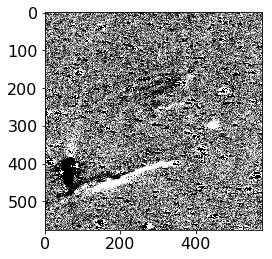

In [240]:
image_path = imgfiles[5]
fitspath = image_path.replace("jpg", "fits.npz")
image_fits = np.load(fitspath)["fitsarr"]
print(fitspath)
image = fits_to_uint8(image_fits, vmin=-1, vmax=1)
plt.imshow(image, cmap='gray')

In [196]:
image_fits.mean(), image_fits.std()

(-16.14686, 311.7009)

In [241]:
steps, mus, stds, imgs = get_mu_std_2d(image_fits, Nstep=30, Nsigma=3)

0 -16.14686 311.7009
1 -0.75792235 25.908321
2 -0.12979655 3.181207
3 -0.035563286 1.0860534
4 -0.012469448 0.79638046
5 -0.02364711 0.70673573
6 -0.023056766 0.68654025
7 -0.02274875 0.6817098
8 -0.022604585 0.68038267
9 -0.022506103 0.679988
10 -0.022506105 0.67988956
11 -0.022522498 0.6798567
12 -0.0225184 0.6798404
13 -0.0225184 0.6798404
14 -0.0225184 0.6798404
15 -0.0225184 0.6798404
16 -0.0225184 0.6798404
17 -0.0225184 0.6798404
18 -0.0225184 0.6798404
19 -0.0225184 0.6798404
20 -0.0225184 0.6798404
21 -0.0225184 0.6798404
22 -0.0225184 0.6798404
23 -0.0225184 0.6798404
24 -0.0225184 0.6798404
25 -0.0225184 0.6798404
26 -0.0225184 0.6798404
27 -0.0225184 0.6798404
28 -0.0225184 0.6798404
29 -0.0225184 0.6798404


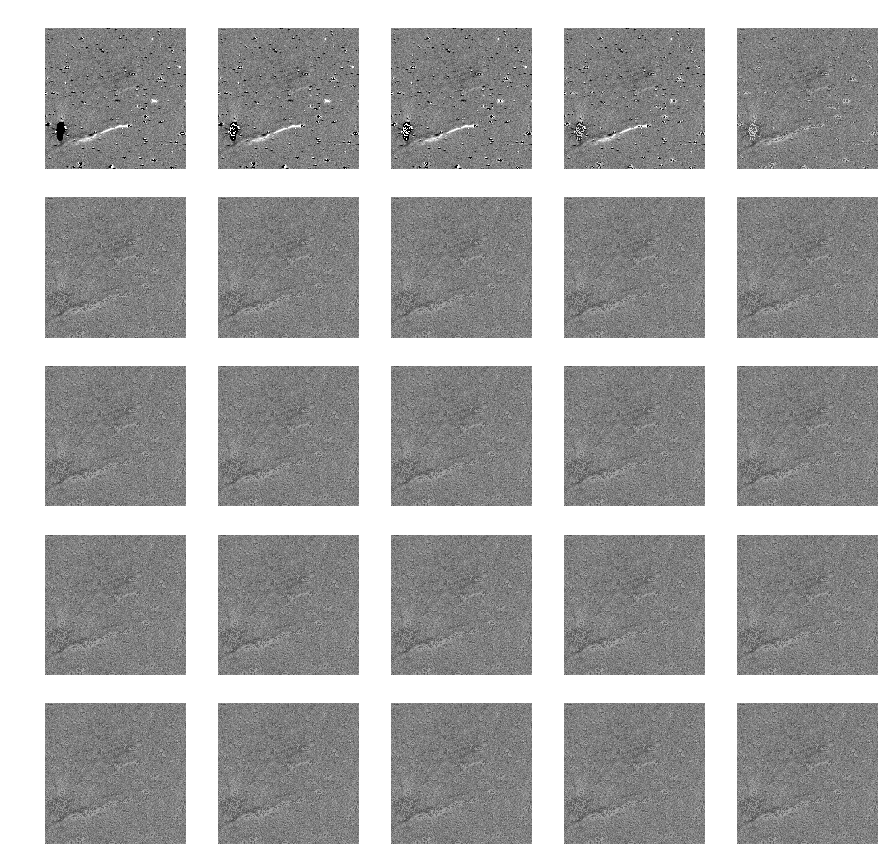

In [243]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs = axs.flatten()

for i in range(25):
    axs[i].matshow(imgs[i], cmap='gray', vmin=-5, vmax=5)
    axs[i].axis('off')


Text(0, 0.5, '$\\Delta$ std')

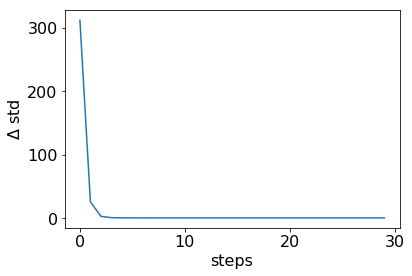

In [244]:
plt.plot(steps, stds)
plt.xlabel('steps')
plt.ylabel('$\Delta$ std')

Text(0, 0.5, '$\\Delta$ mu')

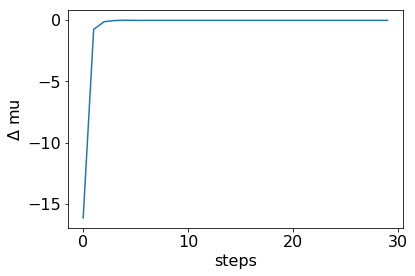

In [245]:
plt.plot(steps, mus)
plt.xlabel('steps')
plt.ylabel('$\Delta$ mu')

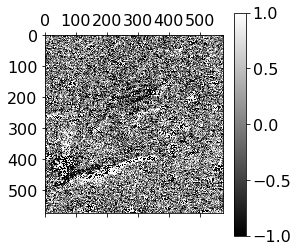

In [214]:
plt.matshow(imgs[10], cmap='gray', vmin=-1, vmax=1)
plt.colorbar()

In [217]:
bboxes = anndic[imgfiles[5]]

In [218]:
bboxes[:, :4]

array([[ 32., 437., 128., 504.],
       [220., 380., 359., 440.],
       [118., 418., 211., 483.],
       [314., 233., 370., 258.],
       [261., 200., 315., 231.],
       [546., 413., 575., 443.],
       [ 77., 147., 103., 173.],
       [ 13., 371., 107., 467.],
       [131., 540., 157., 566.],
       [347., 172., 379., 204.]])

In [219]:
bboxes[:, 4]

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])

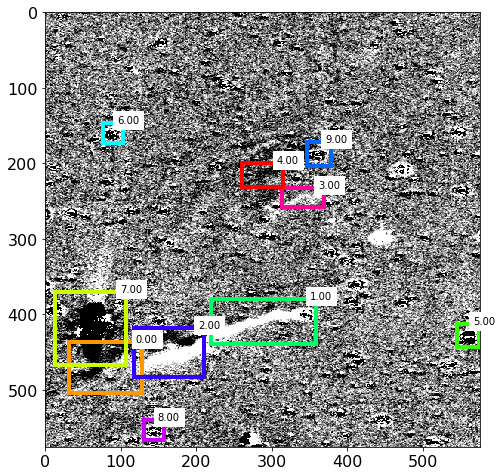

In [220]:
plot_bboxes(imgfiles[5], bboxes, colors=[], labels=np.arange(10), ls='solid', ax=None, figsize=(8, 8), readfits=False, title=None)



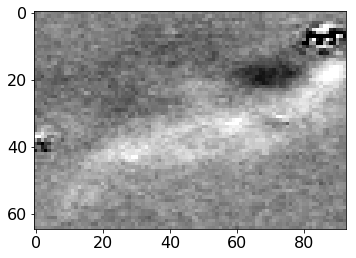

In [319]:
box = bboxes[2].astype(int)

plt.imshow(imgs[20] [ box[1]:box[3], box[0]:box[2]  ], cmap='gray')

In [320]:

box_pixel = image_fits[ box[1]:box[3], box[0]:box[2] ]

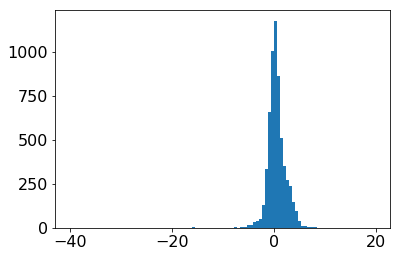

In [321]:
plt.hist(box_pixel.flatten(), bins=100) ;

In [322]:
steps, box_mus, box_stds, box_imgs = get_mu_std(box_pixel, Nstep=50, Nsigma=3)

0 0.50102633 2.041138
1 0.53027344 1.7011214
2 0.53130394 1.6688287
3 0.5315077 1.664614
4 0.53153366 1.6640536
5 0.53153706 1.663979
6 0.53153753 1.6639693
7 0.53153765 1.663968
8 0.53153765 1.6639678
9 0.53153765 1.6639678
10 0.53153765 1.6639678
11 0.53153765 1.6639678
12 0.53153765 1.6639678
13 0.53153765 1.6639678
14 0.53153765 1.6639678
15 0.53153765 1.6639678
16 0.53153765 1.6639678
17 0.53153765 1.6639678
18 0.53153765 1.6639678
19 0.53153765 1.6639678
20 0.53153765 1.6639678
21 0.53153765 1.6639678
22 0.53153765 1.6639678
23 0.53153765 1.6639678
24 0.53153765 1.6639678
25 0.53153765 1.6639678
26 0.53153765 1.6639678
27 0.53153765 1.6639678
28 0.53153765 1.6639678
29 0.53153765 1.6639678
30 0.53153765 1.6639678
31 0.53153765 1.6639678
32 0.53153765 1.6639678
33 0.53153765 1.6639678
34 0.53153765 1.6639678
35 0.53153765 1.6639678
36 0.53153765 1.6639678
37 0.53153765 1.6639678
38 0.53153765 1.6639678
39 0.53153765 1.6639678
40 0.53153765 1.6639678
41 0.53153765 1.6639678
42 0.53

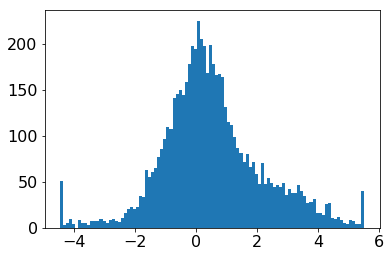

In [323]:
plt.hist(box_imgs[10].flatten(), bins=100) ;

In [324]:
box_pixel.mean(), box_pixel.std()

(0.50102633, 2.041138)

In [131]:
np.random.seed(1)
random_2d = np.random.choice([True, False], imgarr.shape)

random_2d

array([[False, False,  True, ..., False,  True,  True],
       [ True, False,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False,  True, False, ..., False, False,  True],
       [ True, False, False, ...,  True, False,  True],
       [ True,  True,  True, ..., False,  True, False]])

In [138]:
~random_2d

array([[ True,  True, False, ...,  True, False, False],
       [False,  True, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True, False,  True, ...,  True,  True, False],
       [False,  True,  True, ..., False,  True, False],
       [False, False, False, ...,  True, False,  True]])

In [139]:
imgarr[ random_2d ] = -10
imgarr[ ~random_2d ] = 10


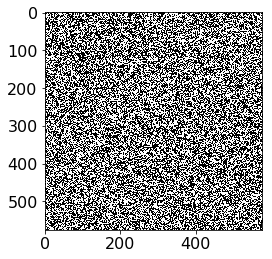

In [141]:
plt.imshow(imgarr, vmin=-10, vmax=10, cmap='gray')


In [239]:
def get_mu_std_2d(imgarr, Nstep=30, Nsigma=5):
    imgarr = imgarr.copy()
    random_2d = np.random.choice([True, False], imgarr.shape)

    steps = []
    mus = []
    stds = []
    imgs = []
    
    #imgarr = image_fits.flatten()
    for i in range(Nstep):
        mu = imgarr.mean()
        std = imgarr.std()
        
        steps.append(i)
        mus.append(mu)
        stds.append(std)
        imgs.append(imgarr.copy())
        print(i, mu, std)

        #imgarr = np.clip(imgarr, mu-Nsigma*std, mu+Nsigma*std)
        #imgarr = imgarr[(imgarr>mu-5*std) & (imgarr<mu+5*std)]
        
        #imgarr[imgarr<mu-Nsigma*std] = mu
        #imgarr[imgarr>mu+Nsigma*std] = mu
        imgarr[ (imgarr<mu-Nsigma*std ) & random_2d ] = mu + std

        imgarr[ (imgarr<mu-Nsigma*std ) & (~random_2d) ] = mu - std
        
        imgarr[ (imgarr>mu+Nsigma*std ) & random_2d ] = mu + std

        imgarr[ (imgarr>mu+Nsigma*std ) & (~random_2d) ] = mu - std
             
    return (steps, mus, stds, imgs)
    

In [13]:
def get_mu_std(imgarr, Nstep=30, Nsigma=5):

    steps = []
    mus = []
    stds = []
    imgs = []
    
    imgarr = imgarr.flatten()
    for i in range(Nstep):
        mu = imgarr.mean()
        std = imgarr.std()
        #imgarr = np.clip(imgarr, mu-Nsigma*std, mu+Nsigma*std)
        #imgarr = imgarr[(imgarr>mu-5*std) & (imgarr<mu+5*std)]
        
        #imgarr[imgarr<mu-Nsigma*std] = mu
        #imgarr[imgarr>mu+Nsigma*std] = mu
        
        steps.append(i)
        mus.append(mu)
        stds.append(std)
        imgs.append(imgarr)
        
        imgarr = imgarr[(imgarr>mu-Nsigma*std) & (imgarr<mu+Nsigma*std)]
        #print(i, mu, std)
    return (steps, mus, stds, imgs)
    

### For all images

In [246]:
mean_all = []
std_all = []
for i, image_path in enumerate( imgfiles ):
    fitspath = image_path.replace("jpg", "fits.npz")
    image_fits = np.load(fitspath)["fitsarr"]
    #print(fitspath)
    #image = fits_to_uint8(image_fits, vmin=-1, vmax=1)
    #plt.imshow(image, cmap='gray')
    steps, mus, stds, imgs = get_mu_std_2d(image_fits, Nstep=50, Nsigma=5)
    mean_all.append(mus[-1])
    std_all.append(stds[-1])


0 -6.956635 183.94081
1 -1.3947104 27.203108
2 -0.30395627 5.563652
3 -0.029519644 2.159809
4 -0.04515974 1.1144507
5 -0.006031849 0.8350964
6 -0.012232243 0.73389363
7 -0.010534541 0.7144887
8 -0.010448343 0.7104691
9 -0.010409894 0.70956373
10 -0.010367108 0.70935816
11 -0.010367108 0.70935816
12 -0.010367108 0.70935816
13 -0.010367108 0.70935816
14 -0.010367108 0.70935816
15 -0.010367108 0.70935816
16 -0.010367108 0.70935816
17 -0.010367108 0.70935816
18 -0.010367108 0.70935816
19 -0.010367108 0.70935816
20 -0.010367108 0.70935816
21 -0.010367108 0.70935816
22 -0.010367108 0.70935816
23 -0.010367108 0.70935816
24 -0.010367108 0.70935816
25 -0.010367108 0.70935816
26 -0.010367108 0.70935816
27 -0.010367108 0.70935816
28 -0.010367108 0.70935816
29 -0.010367108 0.70935816
30 -0.010367108 0.70935816
31 -0.010367108 0.70935816
32 -0.010367108 0.70935816
33 -0.010367108 0.70935816
34 -0.010367108 0.70935816
35 -0.010367108 0.70935816
36 -0.010367108 0.70935816
37 -0.010367108 0.70935816
3

33 0.009818264 0.7774613
34 0.009818264 0.7774613
35 0.009818264 0.7774613
36 0.009818264 0.7774613
37 0.009818264 0.7774613
38 0.009818264 0.7774613
39 0.009818264 0.7774613
40 0.009818264 0.7774613
41 0.009818264 0.7774613
42 0.009818264 0.7774613
43 0.009818264 0.7774613
44 0.009818264 0.7774613
45 0.009818264 0.7774613
46 0.009818264 0.7774613
47 0.009818264 0.7774613
48 0.009818264 0.7774613
49 0.009818264 0.7774613
0 -0.36464834 23.386837
1 -0.17557068 3.1376972
2 -0.14165224 1.1742456
3 -0.13833226 0.84744877
4 -0.13814667 0.79018766
5 -0.13818668 0.779159
6 -0.13810666 0.77704006
7 -0.1381911 0.7766737
8 -0.1381958 0.7766174
9 -0.1381958 0.7766174
10 -0.1381958 0.7766174
11 -0.1381958 0.7766174
12 -0.1381958 0.7766174
13 -0.1381958 0.7766174
14 -0.1381958 0.7766174
15 -0.1381958 0.7766174
16 -0.1381958 0.7766174
17 -0.1381958 0.7766174
18 -0.1381958 0.7766174
19 -0.1381958 0.7766174
20 -0.1381958 0.7766174
21 -0.1381958 0.7766174
22 -0.1381958 0.7766174
23 -0.1381958 0.7766174


12 0.0024378512 0.73163915
13 0.0024378512 0.73163915
14 0.0024378512 0.73163915
15 0.0024378512 0.73163915
16 0.0024378512 0.73163915
17 0.0024378512 0.73163915
18 0.0024378512 0.73163915
19 0.0024378512 0.73163915
20 0.0024378512 0.73163915
21 0.0024378512 0.73163915
22 0.0024378512 0.73163915
23 0.0024378512 0.73163915
24 0.0024378512 0.73163915
25 0.0024378512 0.73163915
26 0.0024378512 0.73163915
27 0.0024378512 0.73163915
28 0.0024378512 0.73163915
29 0.0024378512 0.73163915
30 0.0024378512 0.73163915
31 0.0024378512 0.73163915
32 0.0024378512 0.73163915
33 0.0024378512 0.73163915
34 0.0024378512 0.73163915
35 0.0024378512 0.73163915
36 0.0024378512 0.73163915
37 0.0024378512 0.73163915
38 0.0024378512 0.73163915
39 0.0024378512 0.73163915
40 0.0024378512 0.73163915
41 0.0024378512 0.73163915
42 0.0024378512 0.73163915
43 0.0024378512 0.73163915
44 0.0024378512 0.73163915
45 0.0024378512 0.73163915
46 0.0024378512 0.73163915
47 0.0024378512 0.73163915
48 0.0024378512 0.73163915
4

14 0.09020206 0.77236813
15 0.09020206 0.77236813
16 0.09020206 0.77236813
17 0.09020206 0.77236813
18 0.09020206 0.77236813
19 0.09020206 0.77236813
20 0.09020206 0.77236813
21 0.09020206 0.77236813
22 0.09020206 0.77236813
23 0.09020206 0.77236813
24 0.09020206 0.77236813
25 0.09020206 0.77236813
26 0.09020206 0.77236813
27 0.09020206 0.77236813
28 0.09020206 0.77236813
29 0.09020206 0.77236813
30 0.09020206 0.77236813
31 0.09020206 0.77236813
32 0.09020206 0.77236813
33 0.09020206 0.77236813
34 0.09020206 0.77236813
35 0.09020206 0.77236813
36 0.09020206 0.77236813
37 0.09020206 0.77236813
38 0.09020206 0.77236813
39 0.09020206 0.77236813
40 0.09020206 0.77236813
41 0.09020206 0.77236813
42 0.09020206 0.77236813
43 0.09020206 0.77236813
44 0.09020206 0.77236813
45 0.09020206 0.77236813
46 0.09020206 0.77236813
47 0.09020206 0.77236813
48 0.09020206 0.77236813
49 0.09020206 0.77236813
0 -7.5987563 193.62268
1 -0.47358036 18.24091
2 -0.10348235 3.3260527
3 0.008375451 1.4455564
4 0.05

0 -25.838535 409.78656
1 -1.533215 49.561802
2 -0.106222115 6.0730205
3 0.033061527 1.4557137
4 0.051882897 0.9845572
5 0.053763285 0.772384
6 0.054632034 0.7394963
7 0.054550614 0.7341984
8 0.054581482 0.73360974
9 0.054577064 0.73337066
10 0.054577064 0.73337066
11 0.054577064 0.73337066
12 0.054577064 0.73337066
13 0.054577064 0.73337066
14 0.054577064 0.73337066
15 0.054577064 0.73337066
16 0.054577064 0.73337066
17 0.054577064 0.73337066
18 0.054577064 0.73337066
19 0.054577064 0.73337066
20 0.054577064 0.73337066
21 0.054577064 0.73337066
22 0.054577064 0.73337066
23 0.054577064 0.73337066
24 0.054577064 0.73337066
25 0.054577064 0.73337066
26 0.054577064 0.73337066
27 0.054577064 0.73337066
28 0.054577064 0.73337066
29 0.054577064 0.73337066
30 0.054577064 0.73337066
31 0.054577064 0.73337066
32 0.054577064 0.73337066
33 0.054577064 0.73337066
34 0.054577064 0.73337066
35 0.054577064 0.73337066
36 0.054577064 0.73337066
37 0.054577064 0.73337066
38 0.054577064 0.73337066
39 0.05

Text(0, 0.5, 'std')

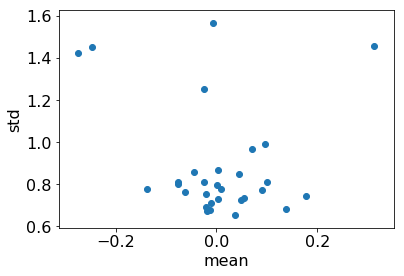

In [247]:
plt.scatter(mean_all, std_all)

plt.xlabel('mean')
plt.ylabel('std')

In [356]:
mean_all, std_all

([-0.01128558,
  0.09166873,
  0.0042275614,
  -0.07710444,
  0.0019678357,
  -0.02432636,
  0.01090419,
  -0.13830693,
  -0.061547536,
  -0.074922524,
  -0.021269385,
  -0.019999318,
  -0.021540433,
  0.001855284,
  -0.014071645,
  0.10349773,
  0.31399074,
  0.13758193,
  0.17853266,
  -0.043117788,
  0.09049481,
  0.07651854,
  0.04580125,
  -0.025309779,
  -0.0055484683,
  -0.24627605,
  -0.2726989,
  0.054491956,
  0.04876134,
  0.037029196],
 [0.66846615,
  0.8645414,
  0.84465665,
  0.7887988,
  0.7765019,
  0.7964438,
  0.74940675,
  0.7315426,
  0.7290773,
  0.7481554,
  0.6986481,
  0.6591901,
  0.68627137,
  0.6919176,
  0.6700681,
  0.7163861,
  1.4168062,
  0.6767302,
  0.7415845,
  0.81077105,
  0.76144797,
  0.896605,
  0.8358906,
  1.2395494,
  1.4508566,
  1.4202371,
  1.3695096,
  0.72258604,
  0.7064578,
  0.6069381])

In [248]:
std_all[25]

1.4512986

./dataset/LE_cand1/tiles/017_0.fits.npz


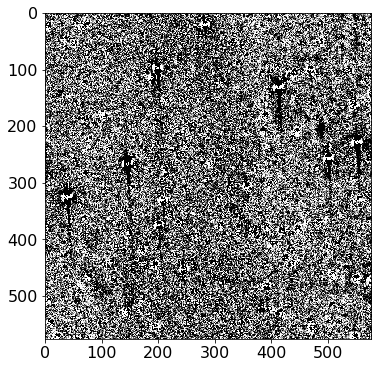

In [249]:
image_path = imgfiles[25]
fitspath = image_path.replace("jpg", "fits.npz")
image_fits = np.load(fitspath)["fitsarr"]
print(fitspath)
image = fits_to_uint8(image_fits, vmin=-1, vmax=1)
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray')